# Tree-based Models

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.chdir('/Users/Vincent/Desktop/Python/DataCamp/Data')

## Classification trees

In [6]:
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

df = pd.read_csv('diabetes.csv')
y = df['Outcome']
X = df.drop('Outcome', axis=1)

# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

# Instantiate a Decision Tree classifier
tree = DecisionTreeClassifier()
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5)
tree_cv.fit(X,y)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 8, 'min_samples_leaf': 2}
Best score is 0.7395833333333334


In [7]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

wbc = pd.read_csv('wbc.csv')
y = wbc.iloc[:,1]
X = wbc.drop(wbc.columns[[0,1,32]], axis=1)

X_train,X_test, y_train,y_test = train_test_split(X,y, test_size=0.3, random_state=42)

# 'different the information criteria
dt_entropy = DecisionTreeClassifier(max_depth=8, criterion='entropy', random_state=1)
dt_entropy.fit(X_train, y_train)
y_pred_entropy = dt_entropy.predict(X_test)

dt_gini = DecisionTreeClassifier(max_depth=8, criterion='gini', random_state=1)
dt_gini.fit(X_train, y_train)
y_pred_gini = dt_gini.predict(X_test)

# Evaluate accuracy_entropy
accuracy_entropy = accuracy_score(y_pred_entropy, y_test)
accuracy_gini = accuracy_score(y_pred_gini, y_test)

print('Accuracy achieved by using entropy: ', accuracy_entropy)
print('Accuracy achieved by using the gini index: ', accuracy_gini)

Accuracy achieved by using entropy:  0.9590643274853801
Accuracy achieved by using the gini index:  0.935672514619883


In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

liver = pd.read_csv('indian_liver_patient_preprocessed.csv')
y = liver.loc[:,'Liver_disease']
X = liver.drop(['Liver_disease'], axis=1)
X = X.drop(X.columns[[0]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1)

params_dt = {
             'max_depth': [2, 3, 4],
             'min_samples_leaf': [0.12, 0.14, 0.16, 0.18]
            }
grid_dt = GridSearchCV(estimator=tree,param_grid=params_dt,scoring='roc_auc',cv=5,n_jobs=-1)
grid_dt.fit(X_train,y_train)

best_model = grid_dt.best_estimator_

# Predict the test set probabilities of the positive class
y_pred_proba = grid_dt.predict_proba(X_test)[:,1]
test_roc_auc = roc_auc_score(y_test,y_pred_proba)
print('Test set ROC AUC score: {:.3f}'.format(test_roc_auc))

Test set ROC AUC score: 0.707


## Regression trees

In [12]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as MSE

mpg = pd.read_csv('auto.csv')

dummies = pd.get_dummies(mpg['origin'], columns=['Asia', 'US', 'Europe'])
df = pd.concat([mpg,dummies], axis=1)
df = df.drop(df[['origin']], axis=1)
y = df.iloc[:,0]
X = df.drop('mpg',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

# training error
dt = DecisionTreeRegressor(max_depth=8,min_samples_leaf=0.13,random_state=3)
dt.fit(X_train, y_train)
y_pred_train = dt.predict(X_train)
RMSE_train = (MSE(y_train, y_pred_train))**(1/2)

# test error
y_pred = dt.predict(X_test)
mse_dt = MSE(y_pred, y_test)
rmse_dt = mse_dt**(1/2)

# Cross-validation error
MSE_CV_scores = - cross_val_score(dt, X,y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
RMSE_CV = MSE_CV_scores.mean()**(1/2)

print('Train RMSE: {:.2f}'.format(RMSE_train))
print("Test set RMSE of dt: {:.2f}".format(rmse_dt))
print('CV RMSE: {:.2f}'.format(RMSE_CV))

Train RMSE: 3.97
Test set RMSE of dt: 4.18
CV RMSE: 4.25


## Ensembles

In [13]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as KNN
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

liver = pd.read_csv('indian_liver_patient_preprocessed.csv')
y = liver.loc[:,'Liver_disease']
X = liver.drop(['Liver_disease'], axis=1)
X = X.drop(X.columns[[0]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1)

# logistic
lr = LogisticRegression(random_state=1)
# knn
knn = KNN(n_neighbors=27)
# decisiontree
dt = DecisionTreeClassifier(min_samples_leaf=0.13, random_state=1)
# Define the list classifiers
classifiers = [('Logistic Regression', lr), ('K Nearest Neighbours', knn), ('Classification Tree', dt)]

# Iterate over the pre-defined list of classifiers
for clf_name, clf in classifiers:    
    clf.fit(X_train, y_train)    
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_pred, y_test) 
   
    print('{:s} : {:.3f}'.format(clf_name, accuracy))
    
vc = VotingClassifier(estimators=classifiers)     
vc.fit(X_train, y_train)   
y_pred = vc.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)
print('Voting Classifier: {:.3f}'.format(accuracy))

Logistic Regression : 0.764
K Nearest Neighbours : 0.701
Classification Tree : 0.730
Voting Classifier: 0.770


## Bagging

In [14]:
from sklearn.ensemble import BaggingClassifier

dt = DecisionTreeClassifier(random_state=1)
bc = BaggingClassifier(base_estimator=dt, 
            n_estimators=50,
            oob_score=True,
            random_state=1)
bc.fit(X_train,y_train)

y_pred = bc.predict(X_test)
acc_test = accuracy_score(y_pred, y_test)
acc_oob = bc.oob_score_

print('Test set accuracy: {:.3f}, OOB accuracy: {:.3f}'.format(acc_test, acc_oob))

Test set accuracy: 0.690, OOB accuracy: 0.706


## Random Forests

In [26]:
from sklearn.ensemble import RandomForestRegressor

bikes = pd.read_csv('bikes.csv')
y = bikes.loc[:,'cnt']
X = bikes.drop(['cnt'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=2)

rf = RandomForestRegressor(n_estimators=25, random_state=2)   
rf.fit(X_train, y_train) 

y_pred = rf.predict(X_test)
rmse_test = MSE(y_test, y_pred)**(1/2)
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))

Test set RMSE of rf: 51.09


## feature selection

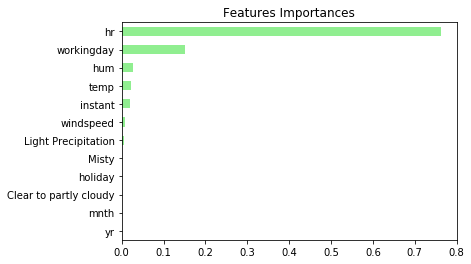

{'hr': 0.76, 'holiday': 0.0, 'workingday': 0.15, 'temp': 0.02, 'hum': 0.03, 'windspeed': 0.01, 'instant': 0.02, 'mnth': 0.0, 'yr': 0.0, 'Clear to partly cloudy': 0.0, 'Light Precipitation': 0.0, 'Misty': 0.0}
Index(['hr', 'workingday'], dtype='object')


In [27]:
# feature importances
importances = pd.Series(data=rf.feature_importances_,index= X_train.columns)
importances_sorted = importances.sort_values()

importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()
# Print the importances per feature
print(dict(zip(X.columns, rf.feature_importances_.round(2))))

# Create a mask for features importances above the threshold
mask = rf.feature_importances_ > 0.10

# Apply the mask to the feature dataset X
reduced_X = X.loc[:,mask]

# prints out the selected column names
print(reduced_X.columns)

In [29]:
from sklearn.feature_selection import RFE
 
# Check whether RFE results in the sae outcome
rfe = RFE(estimator=rf, n_features_to_select=2, step=2, verbose=1)
rfe.fit(X_train, y_train)

mask = rfe.support_
reduced_X = X.loc[:, mask]

print(reduced_X.columns)

Fitting estimator with 12 features.
Fitting estimator with 10 features.
Fitting estimator with 8 features.
Fitting estimator with 6 features.
Fitting estimator with 4 features.
Index(['hr', 'workingday'], dtype='object')


In [57]:
params_rf = {
    'n_estimators':[100,350,500],
    'max_features':['log2','auto','sqrt'],
    'min_samples_leaf':[2,10,30]
}
grid_rf = GridSearchCV(estimator=rf,
                       param_grid=params_rf,
                       scoring='neg_mean_squared_error',
                       cv=3,
                       verbose=1,
                       n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_model = grid_rf.best_estimator_
y_pred = best_model.predict(X_test)

rmse_test = MSE(y_test, y_pred)**(1/2)
print('Test RMSE of best model: {:.3f}'.format(rmse_test)) 

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   16.0s finished


Test RMSE of best model: 52.088


## AdaBoost

In [44]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score

y = liver.loc[:,'Liver_disease']
X = liver.drop(['Liver_disease'], axis=1)
X = X.drop(X.columns[[0]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1)

dt = DecisionTreeClassifier(max_depth=2, random_state=1)
ada = AdaBoostClassifier(base_estimator=dt, n_estimators=180, random_state=1)
ada.fit(X_train,y_train)

# Predicted positive class probabilities
y_pred_proba = ada.predict_proba(X_test)[:,1]

# AUC
ada_roc_auc = roc_auc_score(y_test, y_pred_proba)
print('ROC AUC score: {:.2f}'.format(ada_roc_auc))

ROC AUC score: 0.68


## Gradient Boosting

In [47]:
from sklearn.ensemble import GradientBoostingRegressor

y = bikes.loc[:,'cnt']
X = bikes.drop(['cnt'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=2)

gb = GradientBoostingRegressor(max_depth=4,
                               n_estimators=200,
                               random_state=2)
gb.fit(X_train, y_train)

y_pred = gb.predict(X_test)
mse_test = MSE(y_test, y_pred)
rmse_test = mse_test**(1/2)
print('Test set RMSE of gb: {:.3f}'.format(rmse_test))

Test set RMSE of gb: 49.374


In [50]:
# Stochastic Gradient Boosting
sgbr = GradientBoostingRegressor(max_depth=4, subsample=0.9, max_features=0.75
                                 , n_estimators=200, random_state=2)
sgbr.fit(X_train, y_train)

y_pred = sgbr.predict(X_test)
mse_test = MSE(y_test, y_pred)
rmse_test = mse_test**(1/2)
print('Test set RMSE of Stochastic Gradient Boosting: {:.3f}'.format(rmse_test))

Test set RMSE of Stochastic Gradient Boosting: 50.452
